# Fig 5 - host effect

Need [yield/sev/trait] data from combined dataframes from cluster.

Then get difference.

Then for each variable, get data in the form of dataframe below:

Relies on `cluster/f5_host_run_T.submit`, `cluster/f5_host_run_F.submit` to get data. This produces a load of csvs which are combined via `cluster/host_run_{T/F}_pp.py`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from math import floor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

from colour import Color

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from math import exp, log, log10

from polymodel.config import Config

from polymodel.utils import (
    Fungicide,
    find_beta_vectorised,
    truncated_exp_pdf,
    logit10_vectorised,
    initial_point_distribution,
    trait_vec
)

from polymodel.simulator import SimulatorOneTrait

from polymodel.consts import (
    DEFAULT_I0, 
    DEFAULT_BETA,
    MUTATION_PROP,
    FUNG_MUTATION_SCALE,
    HOST_MUTATION_SCALE,
    DEFAULT_P,
    TRAIN_TEST_SPLIT_PROPORTION
)

from plots.fns import (
    dist_means_as_df,
    get_arrow_annotation,
    get_text_annotation,
    standard_layout,
    traces_with_uncertainty,
    traces_with_uncertainty_bands, 
    hex_to_rgb
)

In [3]:
COLZ = sns.color_palette('muted').as_hex()

## Host on data

In [4]:
host_on = pd.read_csv('../data/05_outputs/fig5/fig5_T.csv')

In [5]:
host_on_yld = (
    host_on
    .filter(like='yld')
    .rename(columns = lambda x: 'y' + x.split('d')[-1])
)

host_on_yld.head(2)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y990,y991,y992,y993,y994,y995,y996,y997,y998,y999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.540391,10.540378,10.540203,10.494212,10.540527,10.487033,10.47449,10.563242,10.561778,10.514065,...,10.541126,10.526683,10.532031,10.524557,10.539847,10.548801,10.528332,10.539384,10.51782,10.52317


In [6]:
host_on_sev = (
    host_on
    .filter(like='sev')
    .rename(columns = lambda x: 'y' + x.split('v')[-1])
)

host_on_sev.head(2)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y990,y991,y992,y993,y994,y995,y996,y997,y998,y999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.300885,0.301021,0.302846,0.782615,0.299465,0.857505,0.988351,0.062499,0.07777,0.575508,...,0.293211,0.443879,0.388094,0.466055,0.306555,0.213144,0.426675,0.311387,0.536335,0.480532


In [7]:
host_on_fm = (
    host_on
    .filter(like='fung')
    .rename(columns = lambda x: 'y' + x.split('mean')[-1])
)

host_on_fm.head(2)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y990,y991,y992,y993,y994,y995,y996,y997,y998,y999
0,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,...,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029
1,0.006920,0.006920,0.006923,0.007382,0.006918,0.007433,0.007515,0.006376,0.006439,0.007220,...,0.006909,0.007093,0.007031,0.007116,0.006928,0.006781,0.007075,0.006934,0.007185,0.007131


## Host off data

In [8]:
host_off = pd.read_csv('../data/05_outputs/fig5/fig5_F.csv')

In [9]:
host_off_yld = (
    host_off
    .filter(like='yld')
    .rename(columns = lambda x: 'y' + x.split('d')[-1])
)

host_off_yld.head(2)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y990,y991,y992,y993,y994,y995,y996,y997,y998,y999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.512154,10.512123,10.511704,10.389,10.51248,10.36832,10.3315,10.560809,10.558227,10.444445,...,10.513912,10.477935,10.491592,10.472399,10.51085,10.531651,10.482185,10.509735,10.454571,10.468764


In [10]:
host_off_sev = (
    host_off
    .filter(like='sev')
    .rename(columns = lambda x: 'y' + x.split('v')[-1])
)

host_off_sev.head(2)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y990,y991,y992,y993,y994,y995,y996,y997,y998,y999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.595445,0.59577,0.600144,1.882801,0.592045,2.099989,2.487534,0.087878,0.114812,1.302084,...,0.577109,0.952415,0.809946,1.010171,0.609052,0.392058,0.908084,0.620687,1.196279,1.048093


In [11]:
host_off_fm = (
    host_off
    .filter(like='fung')
    .rename(columns = lambda x: 'y' + x.split('mean')[-1])
)

host_off_fm.head(2)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y990,y991,y992,y993,y994,y995,y996,y997,y998,y999
0,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,...,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029,0.006029
1,0.007236,0.007236,0.007240,0.007929,0.007233,0.008008,0.008135,0.006476,0.006560,0.007681,...,0.007220,0.007491,0.007399,0.007526,0.007247,0.007035,0.007464,0.007257,0.007628,0.007548


## Combine

In [12]:
yld_df = host_on_yld - host_off_yld

In [13]:
sev_df = host_on_sev - host_off_sev

In [14]:
fm_df = host_on_fm - host_off_fm

## Get host fitting data

In [15]:
host_fit_config = Config(
    'single', 
    n_k=10,
    n_l=500,
    mutation_proportion=MUTATION_PROP,
    mutation_scale_fung=DEFAULT_P * FUNG_MUTATION_SCALE,
    mutation_scale_host=DEFAULT_P * HOST_MUTATION_SCALE,
)

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078654159996959
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_iterations = None
n_k = 10
n_l = 500
n_years = 15
replace_cultivars = None
sprays = None
type = single



## Get fit data

In [16]:
my_df = (
    pd.read_csv(
        '../data/03_model_inputs/control_host.csv'
    )
    .iloc[:, 1:]
    .loc[lambda df: df.cultivar == 'Mariboss']
    .rename(columns={
        'control': 'data_control',
        'min_num': 'n_data',
    })
)

input_severity_df = (
    pd.read_csv(
        '../data/03_model_inputs/input_severities_host.csv'
    )
    .iloc[:, 1:]
    .loc[lambda df: df.cultivar == 'Mariboss']
    .loc[lambda df: df.year <= my_df.year.max()]
)

input_severities = 0.01*np.array(input_severity_df.worst_stb)

n_years = input_severity_df.shape[0]

I0s = [host_fit_config.I0_single] * n_years

betas = find_beta_vectorised(
    input_severities,
    host_fit_config.I0_single
)

NOT_USED_NUM = 0.5

sevs_trait_off = input_severities

output_trait_on = (
    SimulatorOneTrait(
        host_plant_on=True,
        fungicide_on=False,
        config=host_fit_config
    )
    .run_model(
        I0_vec=I0s,
        beta_vec=betas
    )
)

sevs_trait_on = np.asarray(output_trait_on['dis_sev'])

yh = 100 * (1 - sevs_trait_on / sevs_trait_off)

In [48]:
def adding_in_host(yh, sev_data, yield_data, trait_data):
    
    fig = make_subplots(
        rows=2,
        cols=2,
        horizontal_spacing=0.25,
    )
    
    control_df = (
        pd.read_csv('../data/03_model_inputs/control_host.csv')
        .loc[lambda df: df.cultivar=='Mariboss']
        .assign(sizes = lambda df: 3*np.sqrt(df.min_num))
    )
    
    col1 = 'rgba(0,255,0,1)'
    col2 = 'rgba(50,50,50,1)'
    col3 = 'rgba(255,0,0,1)'
    
    
    bds = [2.5, 97.5]
    
    BDS = [5, 25, 75, 95]
    
    
    # ROW 1
    xx = control_df.year
    yy = control_df.control
    
    trc_c = go.Scatter(
        x=xx, y=yy, showlegend=False,
        mode='markers', 
        marker=dict(
            color=COLZ[0],
            opacity=0.5,
            size=control_df.sizes,
        ),
        marker_line_width=1,
        marker_line_color='black',
    )
    
    by_year = (
        control_df
        .groupby('year')
        .mean()
        .reset_index()
        .assign(model_control = yh)
    )
    
    split_year = floor(
        - 1 + by_year.year.min()
        + TRAIN_TEST_SPLIT_PROPORTION * (1 + by_year.year.max() - by_year.year.min())
    )
    
    c_te = by_year.loc[
        lambda df: df.year <= split_year
    ]
    
    c_tr = by_year.loc[
        lambda df: df.year >= split_year
    ]
    
    line_te = go.Scatter(x=c_te.year, y=c_te.model_control, showlegend=False,
               mode='lines', line=dict(color=COLZ[1], width=3))
    
    line_tr = go.Scatter(x=c_tr.year, y=c_tr.model_control, showlegend=False,
               mode='lines', line=dict(color=COLZ[1], width=3, dash='dot'))
    
    trcs_1 = [trc_c, line_te, line_tr]
    
    fig.add_traces(trcs_1, rows=1, cols=1)
    
    
    
    # ROW 2
    
    trcs_dsd = traces_with_uncertainty_bands(sev_data, bds=BDS, color=col1, showlegend=False)
    
    fig.add_traces(trcs_dsd, rows=1, cols=2)
    
    
    
    # ROW 3
        
    trcs_yd = traces_with_uncertainty_bands(yield_data, bds=BDS, color=col1, showlegend=False)
    
    fig.add_traces(trcs_yd, rows=2, cols=1)

    
    # ROW 4
    
    trcs_tm = traces_with_uncertainty_bands(trait_data, bds=BDS, color=col1, showlegend=False)
    
    fig.add_traces(trcs_tm, rows=2, cols=2)
    
    # LAYOUT
    
    x1 = 0.65
    x2 = 0.75
    x3 = 0.85
    x4 = 0.95
    x5 = 1.05
    
    yt=1.11
    yb=1.08
    eps=0.015
    
    col1 = -0.01
    col2 = 0.61
    
    row1 = 1.05
    row2 = 0.475
    
    annotz = [
        get_text_annotation(x1, yb-eps, '5', xanchor='center', yanchor='middle', size=14),
        get_text_annotation(x2, yb-eps, '25', xanchor='center', yanchor='middle', size=14),
        get_text_annotation(x3, yb-eps, '50', xanchor='center', yanchor='middle', size=14),
        get_text_annotation(x4, yb-eps, '75', xanchor='center', yanchor='middle', size=14),
        get_text_annotation(x5, yb-eps, '95', xanchor='center', yanchor='middle', size=14),
        
        
        get_text_annotation(col1, row1, 'A', size=20),
        get_text_annotation(col2, row1, 'B', size=20),
        get_text_annotation(col1, row2, 'C', size=20),
        get_text_annotation(col2, row2, 'D', size=20),
    ]
    
    fig.update_layout(standard_layout(True, height=750))
    fig.update_layout(font=dict(size=14))
    fig.update_layout(annotations=annotz)
     
    fig.update_layout(
        shapes=[
            dict(type="rect", xref="paper", yref="paper",
                 x0=x1,
                 x1=x2,
                 y0=yt,
                 y1=yb,
                 line_width=1,
                 line_color="rgb(0,255,0)",
                 fillcolor="rgb(0,255,0)",
                 opacity=0.1,
            ),
            dict(type="rect", xref="paper", yref="paper",
                 x0=x2,
                 x1=x3,
                 y0=yt,
                 y1=yb,
                 line_width=1,
                 line_color="rgb(0,255,0)",
                 fillcolor="rgb(0,255,0)",
                 opacity=0.2,
            ),
            dict(type="line", xref="paper", yref="paper",
                 x0=x3,
                 x1=x3,
                 y0=yt,
                 y1=yb,
                 line_width=2.5,
                 line_color="rgb(0,255,0)",
                 opacity=1,
            ),
            dict(type="rect", xref="paper", yref="paper",
                 x0=x3,
                 x1=x4,
                 y0=yt,
                 y1=yb,
                 line_width=1,
                 line_color="rgb(0,255,0)",
                 fillcolor="rgb(0,255,0)",
                 opacity=0.2,
            ),
            dict(type="rect", xref="paper", yref="paper",
                 x0=x4,
                 x1=x5,
                 y0=yt,
                 y1=yb,
                 line_width=1,
                 line_color="rgb(0,255,0)",
                 fillcolor="rgb(0,255,0)",
                 opacity=0.1,
            ),
            
            dict(type="line", xref="paper", yref="paper",
                 x0=x1,
                 x1=x1,
                 y0=yb,
                 y1=yb-0.25*eps,
                 line_width=1.5,
                 line_color="rgb(110,110,110)",
                 opacity=1,
            ),
            
            dict(type="line", xref="paper", yref="paper",
                 x0=x2,
                 x1=x2,
                 y0=yb,
                 y1=yb-0.25*eps,
                 line_width=1.5,
                 line_color="rgb(110,110,110)",
                 opacity=1,
            ),
            
            dict(type="line", xref="paper", yref="paper",
                 x0=x3,
                 x1=x3,
                 y0=yb,
                 y1=yb-0.25*eps,
                 line_width=1.5,
                 line_color="rgb(110,110,110)",
                 opacity=1,
            ),
            
            dict(type="line", xref="paper", yref="paper",
                 x0=x4,
                 x1=x4,
                 y0=yb,
                 y1=yb-0.25*eps,
                 line_width=1.5,
                 line_color="rgb(110,110,110)",
                 opacity=1,
            ),
            
            dict(type="line", xref="paper", yref="paper",
                 x0=x5,
                 x1=x5,
                 y0=yb,
                 y1=yb-0.25*eps,
                 line_width=1.5,
                 line_color="rgb(110,110,110)",
                 opacity=1,
            ),
    ])
    
    
    range_ = [-0.5, 15.5]
    
    fig.update_xaxes(title='Year', row=1, col=1)
    fig.update_xaxes(row=1, col=2, range=range_)
    fig.update_xaxes(title='Time (years)', row=2, col=1, range=range_)
    fig.update_xaxes(title='Time (years)', row=2, col=2, range=range_)
    
    fig.update_yaxes(title='Control', row=1, col=1)
    fig.update_yaxes(title='Severity increase (%)', row=1, col=2)
    fig.update_yaxes(title='Yield increase (tons/ha)', row=2, col=1)
    fig.update_yaxes(title='Fungicide trait mean increase', row=2, col=2)
    
    return fig

## FIG

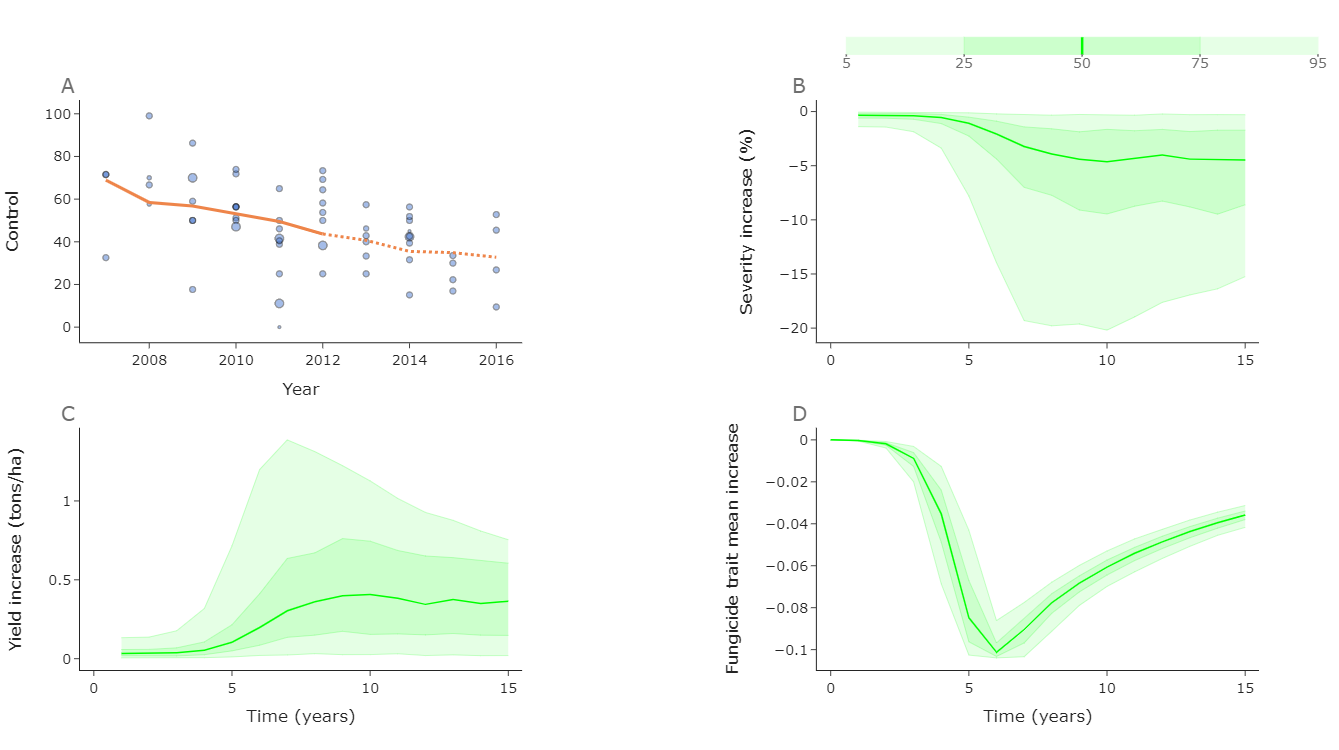

In [49]:
f = adding_in_host(
    yh,
    sev_df,
    yld_df,
    fm_df,
)

f.show()

In [50]:
f.write_image('../figures/paper_figs/fig5_draft.png')